In [1]:
from z3 import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
set_param('parallel.enable', True)
z3.set_param('parallel.threads.max', 8)

# Description
A model that keeps track of the cumulative number of bytes (in/out/lost) until timestep $t$. Each propagation delay is divided into a certain number of timesteps

Here, we do not keep track of where every packet is in the buffer, which will hopefully make things run faster since there are fewer variables (but a similar number of constraints to keep track of the buffer).

The loss model is that if the queue is large enough (according to our dynamic threshold), the sender gets to non-deterministically choose to not accept packets. 

# Parameters
* $R$ - propagation delay (in timesteps)
* $T$ - number of timesteps we simulate (assumed divisible by $R$)
* $C$ - the server's transmission rate (in pkts/timestep)
* $Lmax$ - maximum number of packets in the buffer. It needs to be finite so there are fewer constraints for the SMT solver (otherwise constraints will increase that's all)
* $Lmin$ - minimum buffer size that the non-deterministic server can emulate (Lmin >= 1)
* $K$ - the slack parameter
* CCA - The congestion control algorithm we'll use

# Variables
* $out_t$ - Number of packets output from server till time $t$
* $inp_t$ - Number of packets that have been accepted into the buffer till time $t$
* $lthresh_t$ - Threshold on $inp$ above which packets can be dropped
* $lost_t$ - Number of packets lost till time $t$
* $Ku_t, Kl_t$ - upper and lower slack. Can change if the server decides to waste transmission opportunities

* $cwnd_t$ - cwnd at the beginning of timestep $t$
* $rate_t$ - rate (in pkts / RTT) at during timestep $t$ (i.e. in $[t-1, t)$)

* $loss\_detected_t$ - pkt loss detected at time $t$
* $qdel_t$ - queuing delay measured at time $t$

# Constraints
* The maximum queuing delay is $(K + L) / C$. So that's the number of timesteps we need to check
* $\min(inp_t, C t - Kl_t) \le out_t \le C t + Ku_t$ $\Rightarrow \min(inp_t / C, t - Kl_t / C) \le out_t / C \le t + Ku_t / C$

In [69]:
# The parameters
R = 4
T = 10 * R
C = 1.
Lmax = 10
Lmin = 4
K = 3
CCA = 'AIMD'
# Number of dupacks needed for us to detect loss
dupacks = 0

assert(T % R == 0)
# 1 / C should be an integer
assert(int(1. / C) == 1. / C)
C_inv = int(1. / C)

# Prepare the variables
out = [Real("out_%d" % t) for t in range(T)]
inp = [Real("inp_%d" % t) for t in range(T)]
lthresh = [Real("lthresh_%d" % t) for t in range(T)]
lost = [Real("lost_%d" % t) for t in range(T)]
Ku = [Real("Ku_%d" % t) for t in range(T)]
Kl = [Real("Kl_%d" % t) for t in range(T)]

cwnd = [Real("cwnd_%d" % t) for t in range(T)]
rate = [Real("rate_%d" % t) for t in range(T)]

loss_detected = [Bool("loss_detect_%d" % t) for t in range(T)]

#qdel = [Real("qdel_%d" % t) for t in range(T)]

# Write the constraints
s = Solver()
for t in range(1, T):
    # Constrain the out[t] / C
    s.add(t - Kl[t] * C_inv <= out[t] * C_inv)
    s.add(t + Ku[t] * C_inv >= out[t] * C_inv)
    s.add(out[t-1] <= out[t])
    s.add(inp[t] >= out[t])

    # Determine if we can waste transmissions
    waste_allowed = out[t] >= inp[t-1]
    s.add(Implies(waste_allowed,
                  And(Ku[t] <= Ku[t-1])))
    s.add(Implies(Not(waste_allowed),
                  And(Ku[t] == Ku[t-1],
                      Kl[t] == Kl[t-1])))
    s.add(Ku[t] + Kl[t] == K)
    
    # Either restart lthresh or continue it
    restart_lthresh = (out[t] == inp[t])
    s.add(Implies(restart_lthresh,
                  lthresh[t] == out[t] + (Lmin + 1)))
    
    s.add(Implies(Not(restart_lthresh), lthresh[t] == lthresh[t-1] + C))
    
    # Outputs, windows and rates together decide how input changes
    # Previously total number of packets from the sender
    prev = inp[t-1] + lost[t-1]

    # Input due to rate
    next_r = prev + rate[t]
    # Input due to window
    if t >= R:
        next_w_tmp = out[t-R] + cwnd[t]
        next_w = If(next_w_tmp > prev, next_w_tmp, prev)
    else:
        next_w = cwnd[t]
    # Min of window and rate above two
    s.add(inp[t] + lost[t] == If(next_w < next_r, next_w, next_r))
    
    # If queue length is below threshold, loss isn't allowed
    s.add(Implies(inp[t-1] <= lthresh[t-1], 
                  lost[t] == lost[t-1]))
    # 'inp' and 'lost' are monotonic
    s.add(lost[t] >= lost[t-1])
    s.add(inp[t] >= inp[t-1])
    # Enforce maximum queue length, 'Lmax'
    s.add(inp[t] <= out[t] + Lmax)
    # lthresh cannot exceed Lmax
    s.add(lthresh[t] < out[t] + Lmax)

    # Figure out whether the sender can detect a loss. We'll assume
    # it'll detect with 3 dupack. Haven't implemented timeouts yet.
    
    # For each loss event, figure out when the sender can detect it.
    # Queuing delay can be at most (K + Lmax) / C timesteps

    '''
    # If any in the following list of variables is true,
    # loss_detected is true
    loss_vars = []

    # To figure out when the exiting packets entered the queue. We 
    # need to look back at most (K + Lmax) / C timesteps
    for dt in range(int((K + Lmax) / C) + 1):
        if t - R - dt - 1 < 0:
            # Add constraints that will ensure loss_detected is False if other conditions don't hold
            if t - R - 1 < 0:
                s.add(loss_detected[t] == False)
            break
        # Is this the time when the exiting packets entered the 
        # queue? This is used to calculate queuing delay, but not 
        # loss
        if t - R - dt - 2 >= 0:
            # 'entered' should be true for exactly one dt (the
            # largest one). The If condition ensures this
            entered = If(inp[t - R - dt] != inp[t - R - dt - 1],
                         And(inp[t - R - dt] >= out[t - R], inp[t - R - dt - 1] < out[t - R]),
                         And(inp[t - R - dt] == out[t - R], inp[t - R - dt - 2] < inp[t - R - dt - 1]))
        else:
            # No if condition here. This HAS to be the oldest
            entered = And(inp[t - R - dt] >= out[t - R], inp[t - R - dt - 1] <= out[t - R])
        
        # See if loss happened in any of the periods where inp 
        # crossed (out + 3) (+3 due to dupack requirement)
        crossed = And(inp[t - R - dt] >= out[t - R], 
                      inp[t - R - dt - 1] <= out[t-R])
        # Use crossed to determine if we detect loss now
        loss_var = And(crossed,
                       lost[t - dt] > lost[t - dt - 1])
        loss_vars.append(loss_var)
        # Has loss happened?
        #s.add(Implies(entered,
        #              loss_detected[t] == (lost[t - dt] > lost[t - dt - 1])))
        
    if len(loss_vars) > 0:
        s.add(loss_detected[t] == Or(*loss_vars))'''
        
## Loss detection logic
# If any variable is true in loss_vars[t], loss_detected[t] is true
loss_vars = [[] for _ in range(T)]
for t in range(1, T):
    for dt in range(1, int((K + Lmax) / C + 1.)):
        if t + R + dt >= T:
            break
        loss_vars[t + R + dt].append(And(
            lost[t] > lost[t-1],
            inp[t] + dupacks <= out[t + dt],
            inp[t] + dupacks > out[t + dt - 1]
        ))
for t in range(0, T):
    if len(loss_vars[t]) > 0:
        s.add(loss_detected[t] == Or(*loss_vars[t]))
    else:
        s.add(loss_detected[t] == False)

## Congestion control Logic
for t in range(1, T):
    # Congestion control: enable exactly one of the following
    if CCA == "const":
        # Constant
        s.add(rate[t] == rate[t-1])
        s.add(cwnd[t] == cwnd[t-1])
    elif CCA == "AIMD":
        # AIMD
        # If there was a loss previously within a min RTT, we won't 
        # decrease now even if there is a loss
        prev_loss = Or(*loss_detected[t - R : t])
        # Whether we should decrease cwnd
        decrease = And(loss_detected[t], Not(prev_loss))

        # Increase/decrease window as appropriate
        s.add(Implies(Not(decrease),
                      cwnd[t] == cwnd[t-1] + 1. / R))
        s.add(Implies(decrease,
                      cwnd[t] == cwnd[t-1] / 2.))
        # Infinite rate
        s.add(rate[t] == 10)
    else:
        raise Exception("Unrecognized CCA '%s'" % CCA)


# Our objective

#s.add(inp[-1] > 150)
#s.add(rate[-1] < 6)
s.add(lost[-1] > 1)
#s.add(cwnd[-1] < 10)

# Initial condition
s.add(out[0] == 0); #s.add(out[1] == 0)
s.add(inp[0] == 0);
s.add(lost[0] == 0)
s.add(lthresh[0] == Lmin + 1)
s.add(loss_detected[0] == False)
s.add(Ku[0] == 0); s.add(Kl[0] == K)
s.add(rate[0] == 1)
s.add(cwnd[0] == 4)

In [70]:
#s.set("core.minimize", True)
#s.set(unsat_core=True)
s.check()

sat

In [58]:
s.unsat_core()

[]

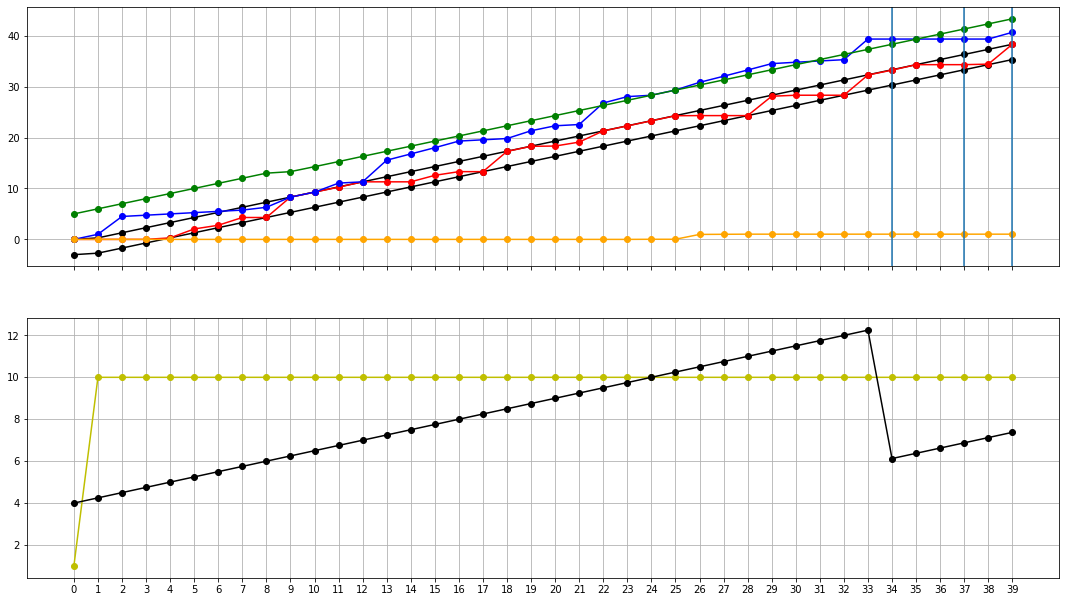

[ 0.      1.      4.5     4.75    5.      5.25    5.5     5.75    6.2976
  8.2976  9.2726 11.0476 11.2976 15.5476 16.7726 17.9976 19.2976 19.5476
 19.7976 21.3226 22.2976 22.5476 26.7726 28.0226 28.2976 29.3226 30.8226
 32.0226 33.2476 34.4976 34.7726 35.0226 35.2726 39.3226 39.3226 39.3226
 39.3226 39.3226 39.3226 40.6476]
[ 0.       0.       0.       0.       0.2976   2.0476   2.7726   4.2976
  4.2976   8.2976   9.2726  10.2476  11.2976  11.2976  11.2976  12.5726
 13.2976  13.2976  17.2726  18.2726  18.3226  19.0976  21.2976  22.2726
 23.2726  24.2726  24.2976  24.2976  24.2976  28.0976  28.2976  28.2976
 28.2976  32.2726  33.2226  34.2976  34.2976  34.2976  34.40385 38.2976 ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.025 0.025 0.975 1.    1.025 1.025 1.025 1.025 1.025 1.025 1.025 1.025
 1.025 1.025 1.025 1.025]


In [71]:
def convert(var):
    decimal = var.as_decimal(100)
    if decimal[-1] == '?':
        decimal = decimal[:-1]
    return float(decimal)

def plot(s):
    global lost
    m = s.model()
    outputs = [convert(m[o]) for o in out]
    inputs = [convert(m[i]) for i in inp]
    upper = [C * t + convert(m[Ku[t]]) for t in range(T)]
    lower = [C * t - convert(m[Kl[t]]) for t in range(T)]
    rates = [convert(m[r]) for r in rate]
    cwnds = [convert(m[w]) for w in cwnd]
    losts = [convert(m[l]) for l in lost]
    lthreshes = [convert(m[l]) for l in lthresh]
    losses_detected = [m[l] for l in loss_detected]
    times = [t for t in range(T)]

    outputs = np.asarray(outputs)
    inputs = np.asarray(inputs)
    upper = np.asarray(upper)
    lower = np.asarray(lower)
    rates = np.asarray(rates)
    cwnds = np.asarray(cwnds)
    losts = np.asarray(losts)
    lthreshes = np.asarray(lthreshes)
    times = np.asarray(times)
    adj = 0 #[B * t for t in range(T)]

    # Configure the plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(18.5, 10.5)
    ax1.grid(True)
    ax2.grid(True)
    ax2.set_xticks(range(0, T))
    ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

    ax1.plot(times, lower - adj, color='black', marker='o')
    ax1.plot(times, upper - adj, color='black', marker='o')
    ax1.plot(times, outputs - adj, color='red', marker='o')
    ax1.plot(times, inputs - adj, color='blue', marker='o')
    ax1.plot(times, lthreshes - adj, color='green', marker='o')
    ax1.plot(times, losts - adj, color='orange', marker='o')
    for (loss_time, pkt_lost) in enumerate(losses_detected):
        if pkt_lost:
            ax1.axvline(x=loss_time)

    ax2.plot(times, rates, color='y', marker='o')
    ax2.plot(times, cwnds, color='black', marker='o')
    #ax2.plot(times[1:], inputs[1:] - inputs[:-1], color='blue', marker='o')
    #ax2.plot(times[1:], outputs[1:] - outputs[:-1], color='red', marker='o')
    #ax2.plot(times[1:], upper[1:] - upper[:-1], color='black', marker='o')
    plt.show()
    
    print(inputs)
    print(outputs)
    print(losts)

plot(s)